# Valley Walking Algorithm

Complete implementation: valley detection → adaptive walking → visualization.

In [17]:
# Package imports
using Globtim
using DynamicPolynomials
using LinearAlgebra
using ForwardDiff
using DataFrames
using Printf

# Plotting setup
using GlobtimPlots
CairoMakie.activate!()

## Setup

In [18]:
# Test function: unit circle valley
f(x) = (x[1]^2 + x[2]^2 - 1)^2

# Configuration
config = (
    gradient_tolerance = 1e-4,
    eigenvalue_threshold = 1e-3,
    initial_step_size = 0.05,      # Larger step for faster traversal
    max_steps = 200,
    max_projection_iter = 10,
    projection_tol = 1e-10
)

(gradient_tolerance = 0.0001, eigenvalue_threshold = 0.001, initial_step_size = 0.05, max_steps = 200, max_projection_iter = 10, projection_tol = 1.0e-10)

## Valley Detection

In [19]:
function detect_valley(f, point, config)
    grad = ForwardDiff.gradient(f, point)
    hess = ForwardDiff.hessian(f, point)
    eigenvals = eigvals(hess)
    
    grad_norm = norm(grad)
    valley_dimension = sum(abs.(eigenvals) .< config.eigenvalue_threshold)
    
    is_critical = grad_norm < config.gradient_tolerance
    is_valley = is_critical && (valley_dimension > 0)
    
    if is_valley
        eigendecomp = eigen(hess)
        valley_mask = abs.(eigendecomp.values) .< config.eigenvalue_threshold
        valley_directions = eigendecomp.vectors[:, valley_mask]
        return true, valley_directions
    end
    return false, nothing
end

# Test on unit circle points
test_points = [[1.0, 0.0], [0.0, 1.0], [-1.0, 0.0], [0.707, 0.707]]
valley_points = []
all_directions = []

for point in test_points
    is_valley, directions = detect_valley(f, point, config)
    if is_valley
        push!(valley_points, point)
        push!(all_directions, directions)
        println("✓ Valley at $(point)")
    end
end

✓ Valley at [1.0, 0.0]
✓ Valley at [0.0, 1.0]
✓ Valley at [-1.0, 0.0]


## Adaptive Valley Walking

In [ ]:
# Helper Functions for Valley Walking

# Project point back onto valley (f(x) ≈ 0) using Newton-like iteration
function project_to_valley(f, point; max_iter=10, tol=1e-10)
    x = copy(point)
    for _ in 1:max_iter
        fval = f(x)
        abs(fval) < tol && break
        g = ForwardDiff.gradient(f, x)
        gnorm2 = dot(g, g)
        gnorm2 < 1e-20 && break
        x .-= (fval / gnorm2) * g
    end
    return x
end

# Get tangent direction from Hessian null space, maintaining continuity with previous direction
function get_valley_tangent(f, point, prev_dir, config)
    hess = ForwardDiff.hessian(f, point)
    eigendecomp = eigen(hess)
    mask = abs.(eigendecomp.values) .< config.eigenvalue_threshold
    any(mask) || return nothing

    dirs = eigendecomp.vectors[:, mask]
    best = dirs[:, 1]
    for j in 1:size(dirs, 2)
        abs(dot(dirs[:, j], prev_dir)) > abs(dot(best, prev_dir)) && (best = dirs[:, j])
    end
    dot(best, prev_dir) < 0 && (best = -best)
    return best / norm(best)
end

In [ ]:
# Method 1: Newton Projection - Take tangent step, then project back to valley
function walk_newton_projection(f, start_point, initial_direction, config)
    steps = [start_point]
    current = copy(start_point)
    direction = initial_direction / norm(initial_direction)
    step_size = config.initial_step_size
    
    for _ in 1:config.max_steps
        tangent = get_valley_tangent(f, current, direction, config)
        isnothing(tangent) && break
        direction = tangent
        
        # Take tangent step
        candidate = current + step_size * direction
        # Project back onto valley
        projected = project_to_valley(f, candidate; 
                                      max_iter=config.max_projection_iter, 
                                      tol=config.projection_tol)
        
        # Accept if projection didn't move too far
        if norm(projected - candidate) < step_size
            current = projected
            push!(steps, copy(current))
            step_size = min(step_size * 1.1, 0.2)
        else
            step_size *= 0.5
            step_size < 1e-8 && break
        end
    end
    return steps
end

# Method 2: Predictor-Corrector - Standard continuation approach
function walk_predictor_corrector(f, start_point, initial_direction, config)
    steps = [start_point]
    current = copy(start_point)
    direction = initial_direction / norm(initial_direction)
    step_size = config.initial_step_size
    
    for _ in 1:config.max_steps
        tangent = get_valley_tangent(f, current, direction, config)
        isnothing(tangent) && break
        direction = tangent
        
        # Predictor: tangent step
        predicted = current + step_size * direction
        # Corrector: Newton projection
        corrected = project_to_valley(f, predicted; 
                                      max_iter=config.max_projection_iter, 
                                      tol=config.projection_tol)
        
        correction_size = norm(corrected - predicted)
        if correction_size < 0.5 * step_size
            # Good step - accept and maybe increase step size
            current = corrected
            push!(steps, copy(current))
            step_size = min(step_size * 1.2, 0.3)
        elseif correction_size < step_size
            # Okay step - accept but reduce step size
            current = corrected
            push!(steps, copy(current))
            step_size *= 0.8
        else
            # Bad step - reduce step size and retry
            step_size *= 0.5
            step_size < 1e-8 && break
        end
    end
    return steps
end

# Run both methods and compare
println("="^60)
println("Valley Walking Methods Comparison")
println("="^60)

methods = [
    ("Newton Projection", walk_newton_projection),
    ("Predictor-Corrector", walk_predictor_corrector)
]

all_results = Dict{String, Dict{String, Any}}()

for (method_name, method_func) in methods
    method_paths = Dict{String, Vector{Vector{Float64}}}()
    time_start = time()
    
    for (i, (point, directions)) in enumerate(zip(valley_points, all_directions))
        for (j, direction) in enumerate(eachcol(directions))
            pos_path = method_func(f, point, direction, config)
            neg_path = method_func(f, point, -direction, config)
            method_paths["p$(i)_d$(j)_pos"] = pos_path
            method_paths["p$(i)_d$(j)_neg"] = neg_path
        end
    end
    
    elapsed = (time() - time_start) * 1000
    
    total_points = sum(length(p) for p in values(method_paths))
    total_arc = sum(
        sum(norm(p[i+1] - p[i]) for i in 1:length(p)-1; init=0.0)
        for p in values(method_paths)
    )
    
    all_results[method_name] = Dict(
        "paths" => method_paths,
        "total_points" => total_points,
        "total_arc_length" => total_arc,
        "time_ms" => elapsed
    )
end

# Print comparison table
println()
println(@sprintf("%-22s  %8s  %12s  %10s", "Method", "Points", "Arc Length", "Time (ms)"))
println("-"^60)
for (method_name, _) in methods
    r = all_results[method_name]
    println(@sprintf("%-22s  %8d  %12.3f  %10.2f", 
        method_name, r["total_points"], r["total_arc_length"], r["time_ms"]))
end
println("="^60)

## Visualization

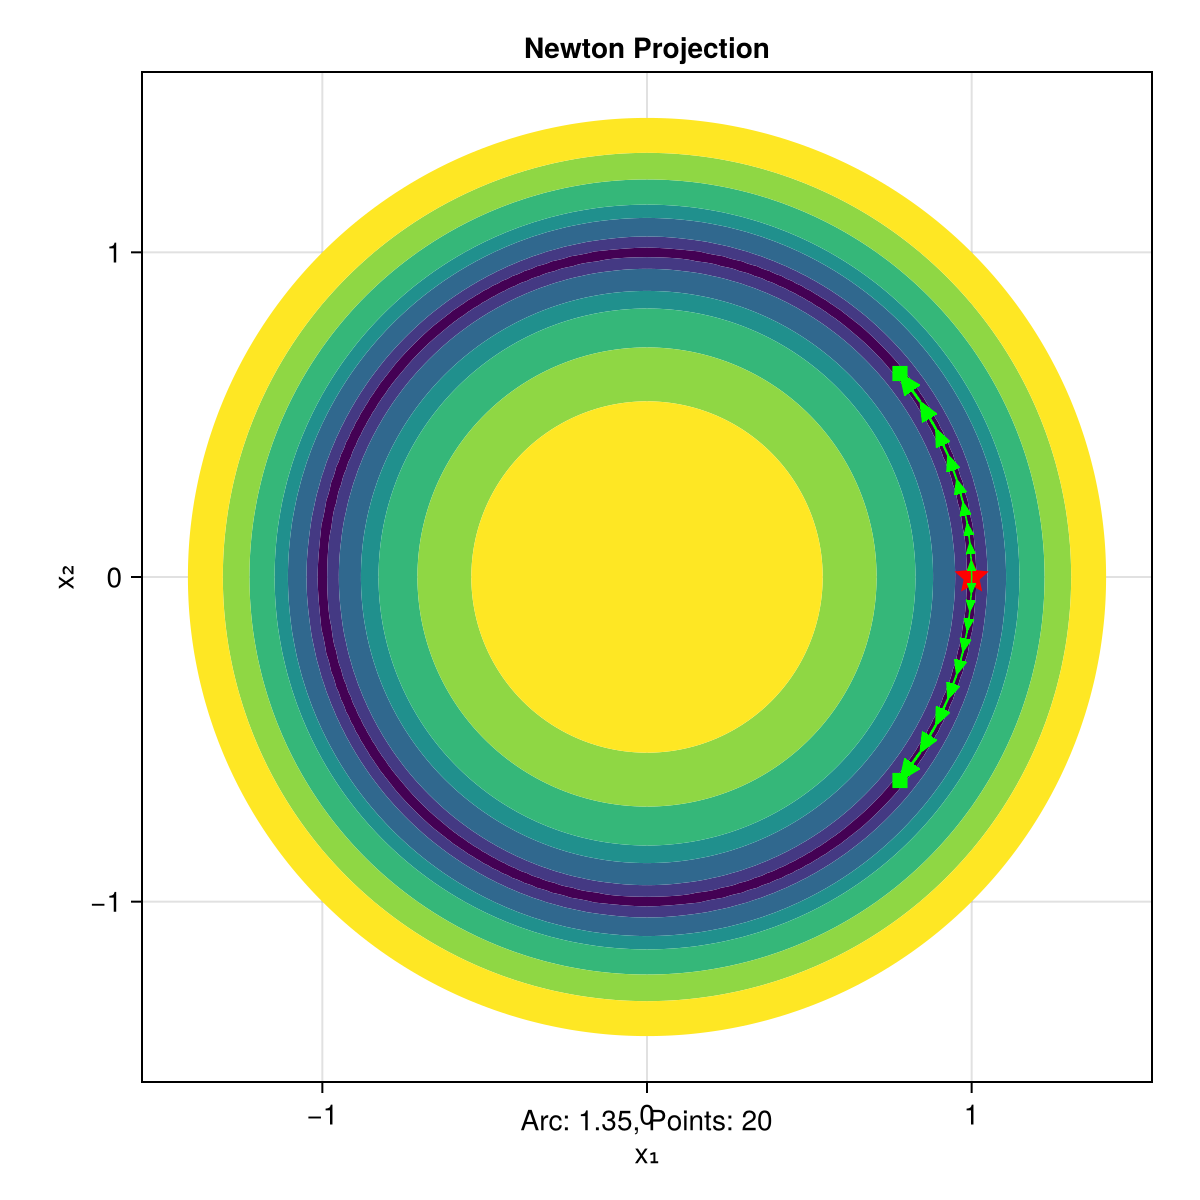

In [22]:
# Newton Projection - Single start point [1.0, 0.0]
start_point = [1.0, 0.0]
start_dir = [0.0, 1.0]  # Tangent to circle at (1,0)
max_display_steps = 10

path_pos = walk_newton_projection(f, start_point, start_dir, config)[1:min(end, max_display_steps)]
path_neg = walk_newton_projection(f, start_point, -start_dir, config)[1:min(end, max_display_steps)]

fig = Figure(size = (600, 600))
ax = Axis(fig[1, 1], xlabel = "x₁", ylabel = "x₂", 
    title = "Newton Projection", aspect = DataAspect())

x_range = range(-1.5, 1.5, length=200)
y_range = range(-1.5, 1.5, length=200)
Z = [f([x, y]) for y in y_range, x in x_range]
levels = [0.0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0]

contourf!(ax, x_range, y_range, Z, levels = levels, colormap = :viridis)

scatter!(ax, [start_point[1]], [start_point[2]], color = :red, markersize = 20, marker = :star5)

for path in [path_pos, path_neg]
    length(path) < 2 && continue
    x_coords = [p[1] for p in path]
    y_coords = [p[2] for p in path]
    
    # Draw arrows showing direction
    dx = diff(x_coords)
    dy = diff(y_coords)
    arrows2d!(ax, x_coords[1:end-1], y_coords[1:end-1], dx, dy,
        color = :lime, shaftwidth = 2, tiplength = 15)
    
    scatter!(ax, [x_coords[end]], [y_coords[end]], color = :lime, markersize = 12, marker = :rect)
end

arc_len = sum(norm(path_pos[i+1] - path_pos[i]) for i in 1:length(path_pos)-1; init=0.0) +
          sum(norm(path_neg[i+1] - path_neg[i]) for i in 1:length(path_neg)-1; init=0.0)
Label(fig[1, 1, Bottom()], @sprintf("Arc: %.2f, Points: %d", arc_len, length(path_pos) + length(path_neg)),
    fontsize = 14, padding = (0, 0, 5, 0))

fig

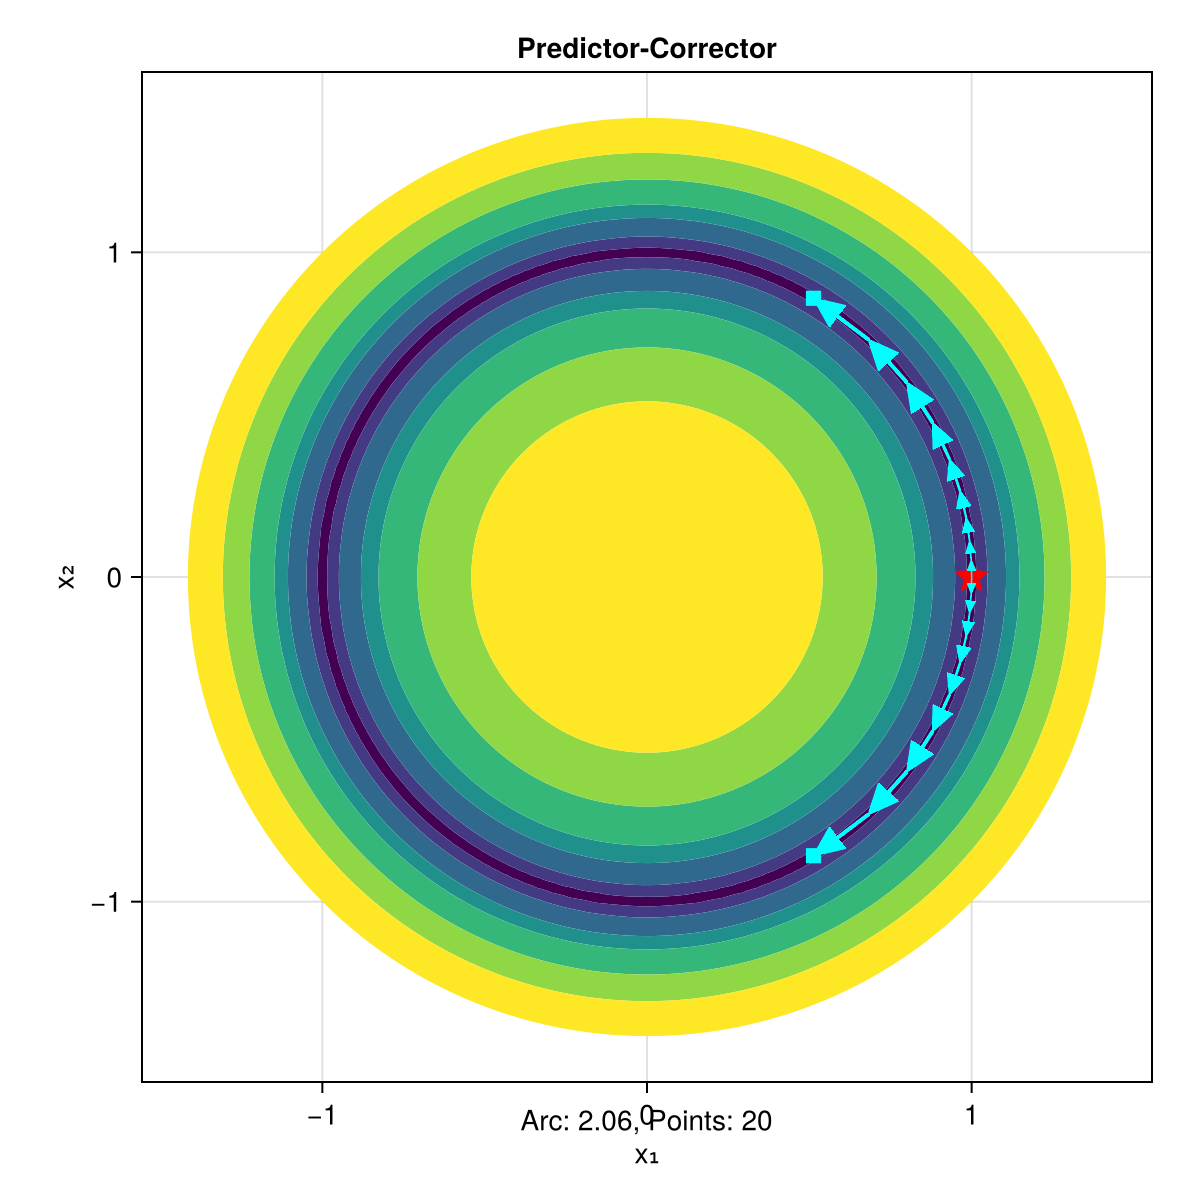

In [23]:
# Predictor-Corrector - Single start point [1.0, 0.0]
path_pos = walk_predictor_corrector(f, start_point, start_dir, config)[1:min(end, max_display_steps)]
path_neg = walk_predictor_corrector(f, start_point, -start_dir, config)[1:min(end, max_display_steps)]

fig = Figure(size = (600, 600))
ax = Axis(fig[1, 1], xlabel = "x₁", ylabel = "x₂", 
    title = "Predictor-Corrector", aspect = DataAspect())

contourf!(ax, x_range, y_range, Z, levels = levels, colormap = :viridis)

scatter!(ax, [start_point[1]], [start_point[2]], color = :red, markersize = 20, marker = :star5)

for path in [path_pos, path_neg]
    length(path) < 2 && continue
    x_coords = [p[1] for p in path]
    y_coords = [p[2] for p in path]
    
    # Draw arrows showing direction
    dx = diff(x_coords)
    dy = diff(y_coords)
    arrows2d!(ax, x_coords[1:end-1], y_coords[1:end-1], dx, dy,
        color = :cyan, shaftwidth = 2, tiplength = 15)
    
    scatter!(ax, [x_coords[end]], [y_coords[end]], color = :cyan, markersize = 12, marker = :rect)
end

arc_len = sum(norm(path_pos[i+1] - path_pos[i]) for i in 1:length(path_pos)-1; init=0.0) +
          sum(norm(path_neg[i+1] - path_neg[i]) for i in 1:length(path_neg)-1; init=0.0)
Label(fig[1, 1, Bottom()], @sprintf("Arc: %.2f, Points: %d", arc_len, length(path_pos) + length(path_neg)),
    fontsize = 14, padding = (0, 0, 5, 0))

fig